# Study beam head rotation, motor angles vs simulation Euler angles 


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=16

# Build a telescope

In [3]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_v0_no_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[0.004, 0.04, 0.15])

0

## Define our rotation function

In [4]:
# function to build a config from motor angles (u, b)
from scipy.spatial.transform import Rotation as transform_rotation

def config_from_angles(beam_config, u, b):
    """ Point a beam configuration to given b and u CCOB motor angles

    Email from Andy:
    - Check that U=0, B rotates around the Y axis, B>0 -> +X, B<0 -> -X
    - Check that U>0 rotates around -Z in the right-handed sense.

    Euler angles in extrinsic rotations
    https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_extrinsic_rotations

    Parameters
    ----------
    beam_config : `ghost.beam_config`
        a beam configuration as a dictionnary
    u : `float`
        the value of the rotation angle in degrees around "Z" (when b=0)
    b : `float`
        the value of the rotation angle in degrees around "Y" (when u=0)

    Returns
    -------
    new_beam : `ghost.beam_config`
        a new beam configuration corresponding to CCOB motor set as (u, b) angles
    """
    # copy input beam configuration
    new_beam = copy.copy(beam_config)
    rot = transform_rotation.from_euler('zxy', [u, 0., b], degrees=True)
    eulers = rot.as_euler('ZXY', degrees=True)
    new_beam['z_euler'] = eulers[0]
    new_beam['x_euler'] = eulers[1]
    new_beam['y_euler'] = eulers[2]
    return new_beam


# Beam head rotation

Direct path is number 15
  central impact point is (0.000003, -0.000001)
  transmission is 0.8298

Maximum expected flux is 0.8298
Maximum bin content is 8328.9860


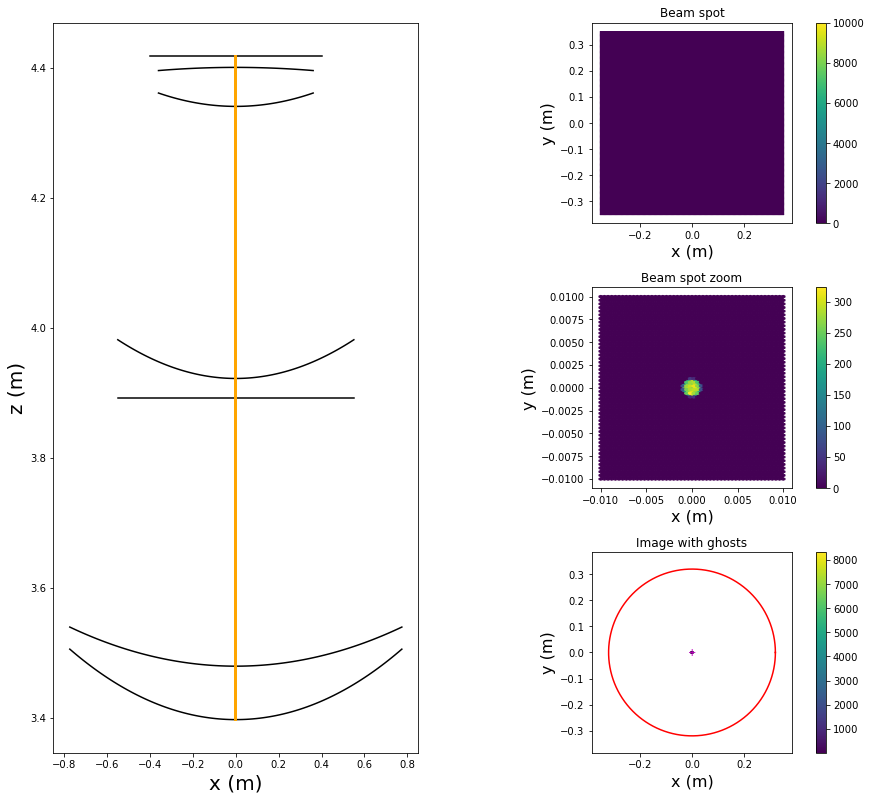

0

In [5]:
# check that the beam correctly points toward center
center_0 = copy.deepcopy(BEAM_CONFIG_0)
center_0['n_photons'] = 10000

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=center_0)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 15
  central impact point is (0.000005, 0.000009)
  transmission is 0.8298

Maximum expected flux is 0.8298
Maximum bin content is 8328.9895


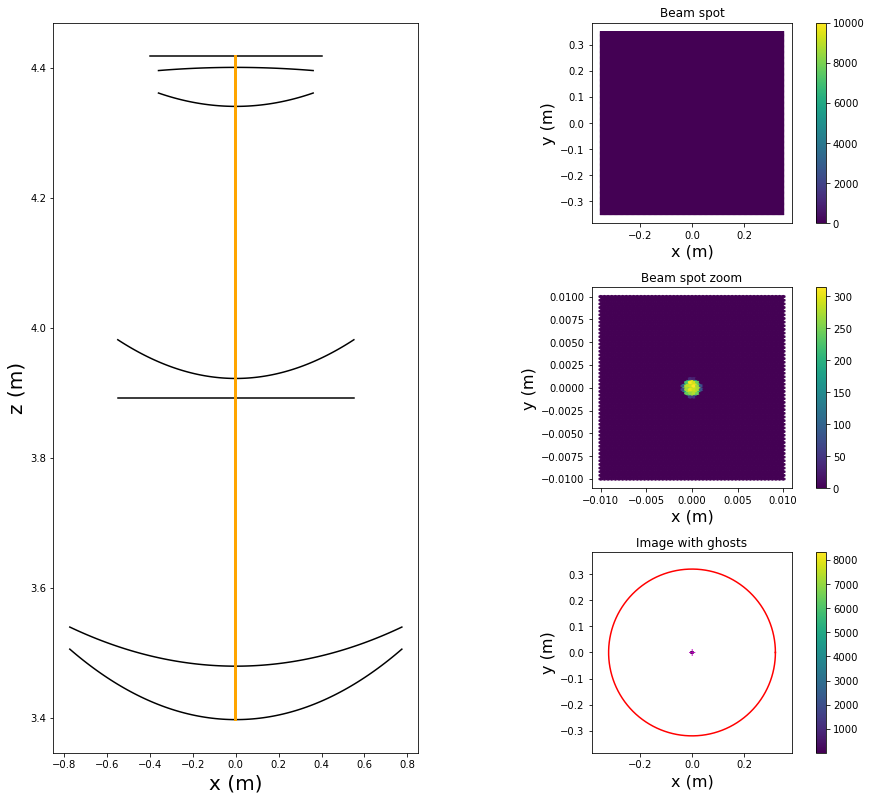

0

In [6]:
# check that the beam correctly points toward center after rotation
center = copy.deepcopy(BEAM_CONFIG_0)
center['n_photons'] = 10000
test_beam = config_from_angles(center, u=0, b=0)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 15
  central impact point is (0.070200, -0.000011)
  transmission is 0.8298

Maximum expected flux is 0.8298
Maximum bin content is 830.6674


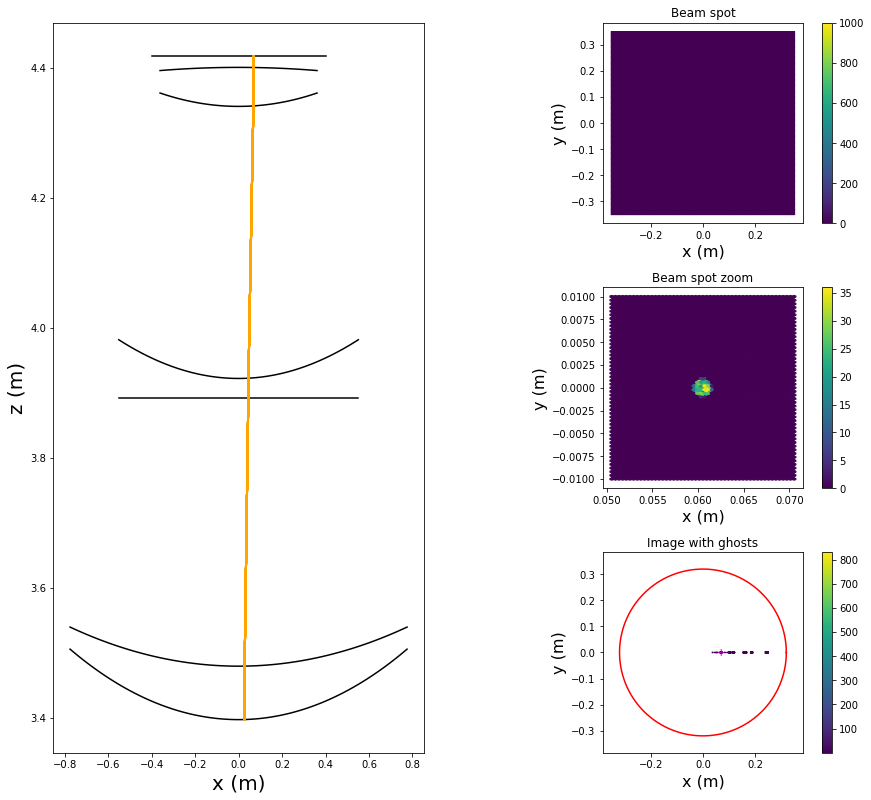

0

In [7]:
# Check that U=0, B rotates the Y axis, B>0 -> +X
center = copy.deepcopy(BEAM_CONFIG_0)
center['n_photons'] = 1000

test_beam = config_from_angles(center, u=0, b=2.5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 13
  central impact point is (-0.140765, 0.000008)
  transmission is 0.8298

Maximum expected flux is 0.8298
Maximum bin content is 829.4670


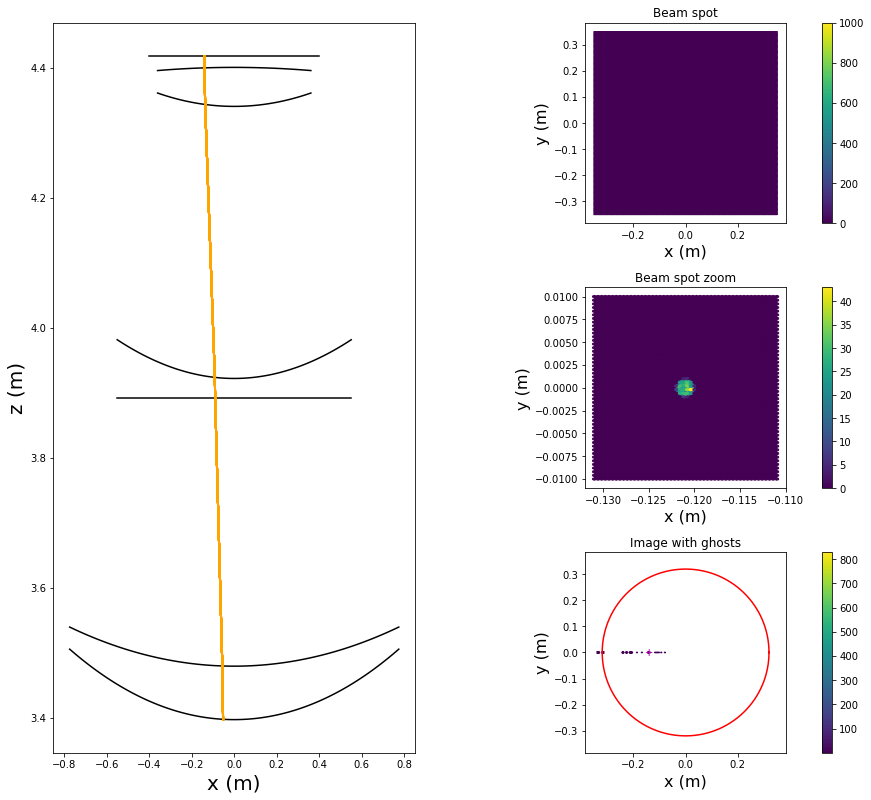

0

In [8]:
# Check that U=0, B rotates the Y axis, B<0 -> -X
center = copy.deepcopy(BEAM_CONFIG_0)
center['n_photons'] = 1000

test_beam = config_from_angles(center, u=0, b=-5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

   beam_id            wl  n_photons   radius  x_offset  y_offset  z_offset  \
0        0  5.000000e-07       1000  0.00125       0.0         0  2.797473   
1        1  5.000000e-07       1000  0.00125       0.0         0  2.797473   
2        2  5.000000e-07       1000  0.00125       0.0         0  2.797473   
3        3  5.000000e-07       1000  0.00125       0.0         0  2.797473   
4        4  5.000000e-07       1000  0.00125       0.0         0  2.797473   

   z_euler  y_euler  x_euler  
0      0.0      0.0      0.0  
1      0.0      2.5      0.0  
2      0.0      5.0      0.0  
3      0.0      7.5      0.0  
4     15.0      0.0      0.0  


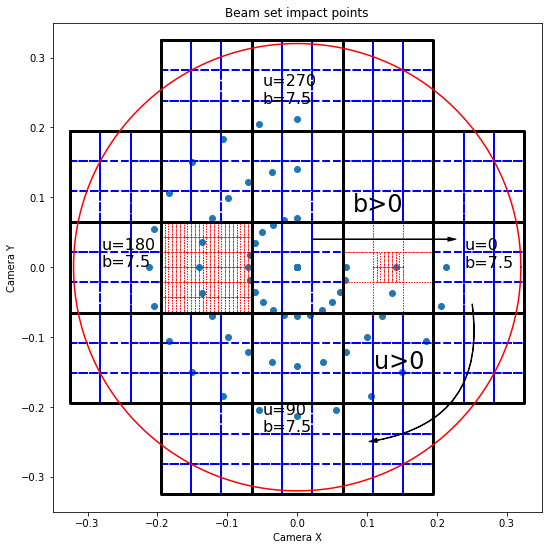

In [9]:
# Check that U=0, B rotates the Y axis, B>0 -> +X, B<0 -> -X
# Check that U>0 rotates around -Z in the right-handed sense
# Check rotation around the clock
beam_set = []
i = 0
for u in range(0, 271, 15):
    for b in np.arange(0, 7.6, 2.5):
        center = copy.deepcopy(BEAM_CONFIG_0)
        beam_conf = config_from_angles(center, u=u, b=b)
        beam_conf['beam_id'] = i
        beam_set.append(beam_conf)
        i = i + 1

# show beam set content
beam_grid = beam.concat_dicts(beam_set)
print(beam_grid.head())

# simulate
impacts_df = simulator.simulate_impact_points_for_beam_set(telescope, beam_set)

# plot
plotter.plot_impact_points_full_frame(impacts_df)
camera = build_camera()
show_camera(plt.gca(), camera)

# some notes
plt.gca().text(0.24, 0.0, "u=0\nb=7.5", fontsize=16)
plt.gca().text(-0.05, -0.235, "u=90\nb=7.5", fontsize=16)
plt.gca().text(-0.28, 0.001, "u=180\nb=7.5", fontsize=16)
plt.gca().text(-0.05, 0.235, "u=270\nb=7.5", fontsize=16)

# rotation sense
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
# rotation for b>0
barrow = patches.FancyArrowPatch((0.02, 0.04), (0.23, 0.04), **kw)
plt.gca().text(0.08, 0.08, "b>0", fontsize=24)
plt.gca().add_patch(barrow)
# rotation for u>0
uarrow = patches.FancyArrowPatch((0.25, -0.05), (0.10, -0.25),
                                connectionstyle="arc3,rad=-.5", **kw)
plt.gca().text(0.11, -0.145, "u>0", fontsize=24)
plt.gca().add_patch(uarrow)

   beam_id            wl  n_photons   radius  x_offset  y_offset  z_offset  \
0        0  5.000000e-07       1000  0.00125       0.1         0  2.797473   
1        1  5.000000e-07       1000  0.00125       0.1         0  2.797473   
2        2  5.000000e-07       1000  0.00125       0.1         0  2.797473   
3        3  5.000000e-07       1000  0.00125       0.1         0  2.797473   
4        4  5.000000e-07       1000  0.00125       0.1         0  2.797473   

   z_euler  y_euler  x_euler  
0      0.0      0.0      0.0  
1      0.0      2.5      0.0  
2      0.0      5.0      0.0  
3      0.0      7.5      0.0  
4     15.0      0.0      0.0  


<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

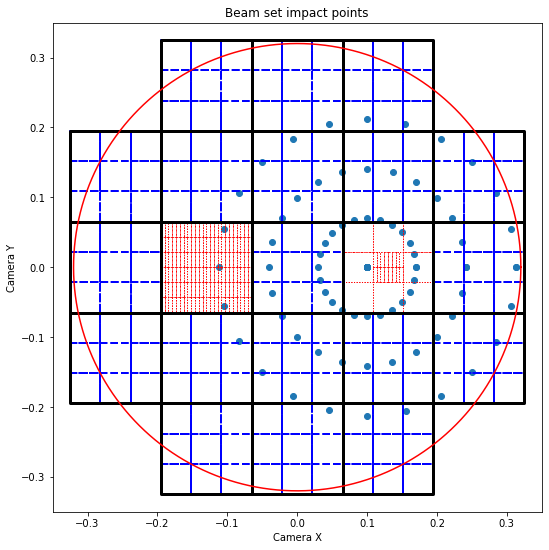

In [10]:
# check rotation around the clock from an off-axis position
beam_set = []
i = 0
for u in range(0, 361, 15):
    for b in np.arange(0, 7.6, 2.5):
        center = copy.deepcopy(BEAM_CONFIG_0)
        beam_conf = config_from_angles(center, u=u, b=b)
        beam_conf['beam_id'] = i
        beam_conf['x_offset'] = 0.1
        beam_conf['x_offset'] = 0.1
        beam_set.append(beam_conf)
        i = i + 1

# show beam set content
beam_grid = beam.concat_dicts(beam_set)
print(beam_grid.head())

# simulate
impacts_df = simulator.simulate_impact_points_for_beam_set(telescope, beam_set)

# plot
plotter.plot_impact_points_full_frame(impacts_df)
camera = build_camera()
show_camera(plt.gca(), camera)


In [11]:
beam_grid

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
0,0,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,0.000000,0.000000
1,1,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,2.500000,0.000000
2,2,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,5.000000,0.000000
3,3,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,7.500000,0.000000
4,4,5.000000e-07,1000,0.00125,0.1,0,2.797473,15.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
95,95,5.000000e-07,1000,0.00125,0.1,0,2.797473,-14.877387,7.247208,-1.935972
96,96,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,0.000000,0.000000
97,97,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,2.500000,0.000000
98,98,5.000000e-07,1000,0.00125,0.1,0,2.797473,0.000000,5.000000,0.000000
